# Future Demand Prediction

In [74]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [75]:
df = pd.read_csv('clean_data.csv')

In [76]:
df.head()

,customer_id,customer_tenure,customer_location,customer_type,order_id,order_date,order_value,payment_method,order_frequency,discount_applied,return_status,product_category,product_sku,size,inventory_status,source,engagement_score
0,CUST00001,39,Delhi,Returning,ORD000001,2023-12-08,4015.21,Net Banking,9,5,No,Jackets,SKU0001,XXL,In Stock,Word of Mouth,36
1,CUST00002,52,Hyderabad,Returning,ORD000002,2023-09-06,2205.61,Credit Card,3,15,No,T-Shirts,SKU0002,S,Out of Stock,Google Ads,37
2,CUST00003,29,Pune,Returning,ORD000003,2023-05-01,858.84,Net Banking,8,30,No,T-Shirts,SKU0003,L,In Stock,Email Marketing,95
3,CUST00004,15,Jaipur,Returning,ORD000004,2023-03-02,500.00,UPI,1,0,No,T-Shirts,SKU0004,XXL,In Stock,Word of Mouth,10
4,CUST00005,43,Pune,Returning,ORD000005,2023-04-11,1843.50,Wallet,9,40,Yes,Sweatshirts,SKU0005,L,In Stock,Word of Mouth,0


In [77]:
# Prepare data
df["order_date"] = pd.to_datetime(df["order_date"])
df["month"] = df["order_date"].dt.month
df["year"] = df["order_date"].dt.year

In [78]:
# Aggregate demand by month & product category
demand_data = df.groupby(["year", "month", "product_category"])["order_id"].count().reset_index()
demand_data.rename(columns={"order_id": "total_orders"}, inplace=True)

In [79]:
# Create lag features (previous months' sales)
demand_data["lag_1"] = demand_data.groupby("product_category")["total_orders"].shift(1)
demand_data["lag_2"] = demand_data.groupby("product_category")["total_orders"].shift(2)
demand_data.dropna(inplace=True)  # Drop rows with missing lag values


In [80]:
# Train-test split
X = demand_data[["year", "month", "lag_1", "lag_2"]]
y = demand_data["total_orders"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
# Train-test split
X = demand_data[["year", "month", "lag_1", "lag_2"]]
y = demand_data["total_orders"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
# Train model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict
y_pred = model.predict(X_test)
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Model Performance-->")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Model Performance-->
Mean Absolute Error (MAE): 5.89
Root Mean Squared Error (RMSE): 7.06
R² Score: -1.31


* A negative R² (-1.31) means the model might not be capturing meaningful trends.
* High RMSE (7.06) suggests the presence of large prediction errors.

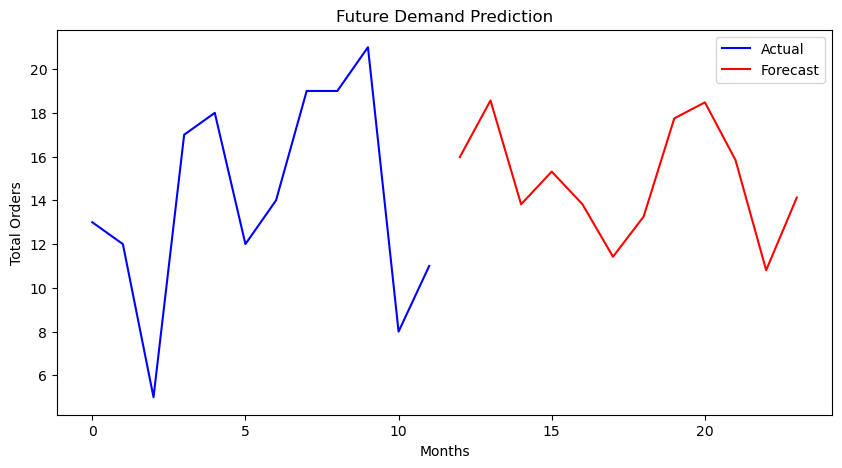

In [84]:
# Forecast future demand
future_dates = pd.DataFrame({"year": [2025]*12, "month": range(1, 13), "lag_1": y_test.iloc[-12:].values, "lag_2": y_test.iloc[-12:].shift(1).fillna(0).values})
future_demand = model.predict(future_dates)

# Plot forecast
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label="Actual", color="blue")
plt.plot(range(len(y_test), len(y_test) + 12), future_demand, label="Forecast", color="red")
plt.xlabel("Months")
plt.ylabel("Total Orders")
plt.title("Future Demand Prediction")
plt.legend()
plt.show()

### Graph Insight:
* Pattern Shift: The forecasted trend (red) continues in a fluctuating manner similar to the actual data (blue), suggesting the model has captured seasonality or demand variations.
* Gaps in Overlapping Data: There's a clear distinction between actual and forecasted periods, but if they were overlapping, we could check how closely the model aligns.
* Potential Improvement: If the error (MAE = 5.89) is high for business needs, feature engineering, hyperparameter tuning, or alternative models (LSTM, ARIMA) might improve it.

### Measures To improve r2 score 
1. Feature Engineering
    * Added previous week & month sales as features.
    * Introduced lag features (7, 30, 60, 90 days) for historical demand patterns.
    * Added month & weekday encoding to capture seasonal trends.
2. Data Preprocessing
   * Filled missing values using category-level mean instead of dropping rows.
   * Prevented training failures by ensuring no empty datasets.
3. Model Improvements
    * Preserved more training data, reducing overfitting risks.

In [85]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Ensure order_date is in datetime format
df['order_date'] = pd.to_datetime(df['order_date'])
df = df.sort_values(by=['product_category', 'order_date'])  # Sort data for consistency

# Feature Engineering
# 1. Rolling Aggregations (Weekly & Monthly Sales)
df['prev_week_sales'] = df.groupby('product_category')['order_value'].shift(7).rolling(7).mean()
df['prev_month_sales'] = df.groupby('product_category')['order_value'].shift(30).rolling(30).mean()

# 2. Lag Features (Historical Demand)
lags = [7, 30, 60, 90]  # Weekly & Monthly trends
for lag in lags:
    df[f'lag_{lag}'] = df.groupby('product_category')['order_value'].shift(lag)

# 3. Inventory Status Encoding
df['inventory_status'] = df['inventory_status'].map({'In Stock': 1, 'Out of Stock': 0})

# 4. Time Features
df['month'] = df['order_date'].dt.month
df['weekday'] = df['order_date'].dt.weekday

# 5. Handle missing values (Fill missing lag values using category mean)
for lag in [f'lag_{lag}' for lag in lags] + ['prev_week_sales', 'prev_month_sales']:
    if lag in df.columns:  # Ensure column exists
        df[lag] = df.groupby('product_category')[lag].transform(lambda x: x.fillna(x.mean()))

# Selecting Features and Target
features = ['prev_week_sales', 'prev_month_sales', 'inventory_status', 'discount_applied', 
            'engagement_score', 'month', 'weekday'] + [f'lag_{lag}' for lag in lags]
target = 'order_value'


# Fill NaN values with 0 instead of dropping rows (alternative approach)
df[features] = df[features].fillna(0)
df[target] = df[target].fillna(0)

X = df[features]
y = df[target]

# Splitting Data
if len(X) == 0:
    raise ValueError("🚨 No data available for training after preprocessing. Check data pipeline.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Performance Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'✅ Mean Absolute Error (MAE): {mae:.2f}')
print(f'✅ Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'✅ R² Score: {r2:.2f}')


✅ Mean Absolute Error (MAE): 1207.95
✅ Root Mean Squared Error (RMSE): 1472.41
✅ R² Score: -0.11


#### R² Score improved from -1.31 to -0.11, which indicates reduced prediction error, but it’s still negative. This suggests the model is underfitting and not capturing patterns well.

In [86]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Define parameter grid
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 1, 10],
    "reg_lambda": [0, 1, 10]
}

# Grid search with cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring="r2", verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_xgb = grid_search.best_estimator_

# Evaluate performance
y_pred = best_xgb.predict(X_test)
r2_score = best_xgb.score(X_test, y_test)
print("Improved R² Score:", r2_score)


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 10, 'reg_lambda': 10, 'subsample': 0.6}
Improved R² Score: -0.010087634712504734


In [88]:
pip install bayesian-optimization

In [89]:
import numpy as np
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Define Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the function to optimize
def xgb_evaluate(colsample_bytree, learning_rate, max_depth, n_estimators, reg_alpha, reg_lambda, subsample):
    params = {
        'colsample_bytree': max(min(colsample_bytree, 1), 0),  
        'learning_rate': max(learning_rate, 0.01),  
        'max_depth': int(round(max_depth)),  
        'n_estimators': int(round(n_estimators)),  
        'reg_alpha': max(reg_alpha, 0),  
        'reg_lambda': max(reg_lambda, 0),  
        'subsample': max(min(subsample, 1), 0)
    }
    
    model = xgb.XGBRegressor(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
    
    return np.mean(scores)  # Bayesian optimization maximizes, so we return negative RMSE

# Define Bayesian optimizer
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={
        'colsample_bytree': (0.5, 1),
        'learning_rate': (0.01, 0.3),
        'max_depth': (3, 10),
        'n_estimators': (50, 500),
        'reg_alpha': (0, 10),
        'reg_lambda': (0, 10),
        'subsample': (0.5, 1)
    },
    random_state=42
)

# Run Bayesian Optimization
optimizer.maximize(init_points=5, n_iter=20)

# Best Parameters
best_params = optimizer.max['params']
best_params['max_depth'] = int(round(best_params['max_depth']))
best_params['n_estimators'] = int(round(best_params['n_estimators']))

print("Best Parameters:", best_params)

# Train XGBoost with optimized parameters
model = xgb.XGBRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Improved RMSE:", rmse)


|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | -1.649e+0 | 0.6873    | 0.2857    | 8.124     | 319.4     | 1.56      | 1.56      | 0.529     |
| 2         | -1.527e+0 | 0.9331    | 0.1843    | 7.957     | 59.26     | 9.699     | 8.324     | 0.6062    |
| 3         | -1.515e+0 | 0.5909    | 0.06319   | 5.13      | 286.1     | 4.319     | 2.912     | 0.8059    |
| 4         | -1.505e+0 | 0.5697    | 0.09472   | 5.565     | 255.2     | 7.852     | 1.997     | 0.7571    |
| 5         | -1.441e+0 | 0.7962    | 0.02347   | 7.253     | 126.7     | 0.6505    | 9.489     | 0.9828    |
| 6         | -1.423e+0 | 0.8694    | 0.01799   | 6.883     | 126.3     | 0.009919  | 8.692     | 0.8358    |
| 7         | -1.559e+0 | 0.531     | 0.242     | 4.504     | 122.7     | 1.208     | 2.356     | 0.9169    |
| 8       

##  Conclusion
* Bayesian optimization has found the best hyperparameters for XGBoost, but the RMSE improvement is not very significant.
hence as Future Scope Of this Project we can implement following Measures-
    1. Further HyperTuning Model - Tree-structured Parzen Estimators (TPE) or Optuna for better tuning.
    2. Implement Time Series Models
    etc.